三、时间信息

3.1 获取每月销量
如果本月本车型没有销量，那么销量为0

3.2 已销售时间
计算本车型已经销售的时间
如果从2012年1月至今销量为0，那么本车在本月还为上市，直到有销量的月份，已销售时间设为1，并随之间增长

3.3 上月总销量与本车型销量

3.4 去年总销量与本车型销量

3.5 本月共有多少种车型在销售

In [21]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

In [3]:
train = pd.read_csv('../../raw/CarsSaleForecast/[new] yancheng_train_20171226.csv')
test = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')
trainFeature = pd.read_csv('../../raw/LiChuan/train_feature.csv')

In [4]:
trainDate = train[['sale_date', 'sale_quantity', 'class_id']]
trainDate = trainDate.groupby(['sale_date', 'class_id']).agg('sum').reset_index()
trainDate['year'] = trainDate['sale_date'].apply(lambda x: int(str(x)[0:4]))
trainDate['mouth'] = trainDate['sale_date'].apply(lambda x: int(str(x)[4:6]))
# trainDate = trainDate.drop(['sale_date'], axis=1)
trainDate.head()

,sale_date,class_id,sale_quantity,year,mouth
0,201201,125403,90,2012,1
1,201201,136916,665,2012,1
2,201201,178529,1739,2012,1
3,201201,194450,65,2012,1
4,201201,198427,47,2012,1


In [5]:
trainSaleDate = trainFeature

# 2012年1月的销量信息
trainTmp = trainDate[(trainDate['year']==2012)&(trainDate['mouth']==1)]
# trainTmp = trainTmp[trainTmp['mouth']==1]
trainTmp.loc[:, 'how_many_mouth_has_sell'] = 1
sale_class_count = len(trainTmp)

trainSaleDate = pd.merge(trainSaleDate, trainTmp, on='class_id', how='left')
trainSaleDate['year'].fillna(2012, inplace=True)
trainSaleDate['mouth'].fillna(1, inplace=True)
# trainSaleDate['how_many_mouth_has_sell'].fillna(0.0, inplace=True)
trainSaleDate.loc[:, 'sale_quantity_total_last_mouth'] = 0
trainSaleDate.loc[:, 'sale_quantity_this_last_mouth'] = 0
trainSaleDate.loc[:, 'this_mouth_sale_class_count'] = sale_class_count
trainSaleDate.head()

,class_id,brand_id_12,brand_id_49,brand_id_68,brand_id_75,brand_id_76,brand_id_98,brand_id_106,brand_id_126,brand_id_236,...,rated_passenger_7-8,rated_passenger_9,sale_date,sale_quantity,year,mouth,how_many_mouth_has_sell,sale_quantity_total_last_mouth,sale_quantity_this_last_mouth,this_mouth_sale_class_count
0,125403,0,0,0,0,0,0,0,0,0,...,0,0,201201.0,90.0,2012.0,1.0,1.0,0,0,42
1,136916,0,0,0,0,0,0,1,0,0,...,0,0,201201.0,665.0,2012.0,1.0,1.0,0,0,42
2,178529,0,0,0,0,0,1,0,0,0,...,0,0,201201.0,1739.0,2012.0,1.0,1.0,0,0,42
3,194450,0,0,0,0,0,0,0,0,0,...,0,0,201201.0,65.0,2012.0,1.0,1.0,0,0,42
4,198427,1,0,0,0,0,0,0,0,0,...,0,0,201201.0,47.0,2012.0,1.0,1.0,0,0,42


In [7]:
for mouth in range(2, 13):
    trainSaleDateTmp = trainFeature
    trainTmp = trainDate[(trainDate['year']==2012)&(trainDate['mouth']==mouth)]
    
    sellmouth = trainSaleDate[['class_id', 'how_many_mouth_has_sell', 'sale_quantity']][(trainSaleDate['year']==2012)&(trainSaleDate['mouth']==(mouth-1))]
    sellmouth.dropna(inplace=True)
    sellmouth['how_many_mouth_has_sell'] = sellmouth['how_many_mouth_has_sell']+1
    sale_quantity_total_last_mouth = sellmouth['sale_quantity'].sum()
    sellmouth.rename(columns={'sale_quantity': 'sale_quantity_this_last_mouth'}, inplace=True)
    
    trainTmp = pd.merge(trainTmp, sellmouth, on='class_id', how='left')
    trainTmp['how_many_mouth_has_sell'].fillna(1.0, inplace=True)
    sale_class_count = len(trainTmp)
    
    trainSaleDateTmp = pd.merge(trainSaleDateTmp, trainTmp, on='class_id', how='left')
    trainSaleDateTmp['year'].fillna(2012.0, inplace=True)
    trainSaleDateTmp['mouth'].fillna(mouth, inplace=True)
    trainSaleDateTmp.loc[:, 'sale_quantity_total_last_mouth'] = sale_quantity_total_last_mouth
    trainSaleDateTmp.loc[:, 'this_mouth_sale_class_count'] = sale_class_count
    
    trainSaleDate = pd.concat([trainSaleDate, trainSaleDateTmp])
    
trainSaleDate.loc[:, 'sale_quantity_total_last_year'] = 0
trainSaleDate.loc[:, 'sale_quantity_this_last_year'] = 0

In [8]:
# 加入 2013-2016 年数据
for year in range(2013, 2017):
    for mouth in range(1, 13):
        trainSaleDateTmp = trainFeature
        trainTmp = trainDate[(trainDate['year']==year)&(trainDate['mouth']==mouth)]
        
        if mouth == 1:
            sellmouth = trainSaleDate[['class_id', 'how_many_mouth_has_sell', 'sale_quantity']][(trainSaleDate['year']==(year-1))&(trainSaleDate['mouth']==12)]
        else:
            sellmouth = trainSaleDate[['class_id', 'how_many_mouth_has_sell', 'sale_quantity']][(trainSaleDate['year']==year)&(trainSaleDate['mouth']==(mouth-1))]
        sellmouth.dropna(inplace=True)
        sellmouth['how_many_mouth_has_sell'] = sellmouth['how_many_mouth_has_sell']+1
        sale_quantity_total_last_mouth = sellmouth['sale_quantity'].sum()
        sellmouth.rename(columns={'sale_quantity': 'sale_quantity_this_last_mouth'}, inplace=True)
        
        sellYear = trainSaleDate[['class_id', 'sale_quantity']][((trainSaleDate['year']==(year-1))&(trainSaleDate['mouth']>=mouth))|((trainSaleDate['year']==year)&(trainSaleDate['mouth']<mouth))]
        sellYear.dropna(inplace=True)
        sellYear = sellYear.groupby('class_id').agg('sum').reset_index()
        sale_quantity_total_last_year = sellYear['sale_quantity'].sum()
        sellYear.rename(columns={'sale_quantity': 'sale_quantity_this_last_year'}, inplace=True)
        
        trainTmp = pd.merge(trainTmp, sellmouth, on='class_id', how='left')
        trainTmp['how_many_mouth_has_sell'].fillna(1.0, inplace=True)
        sale_class_count = len(trainTmp)
        
        trainTmp = pd.merge(trainTmp, sellYear, on='class_id', how='left')
        
        trainSaleDateTmp = pd.merge(trainSaleDateTmp, trainTmp, on='class_id', how='left')
        trainSaleDateTmp['year'].fillna(year, inplace=True)
        trainSaleDateTmp['mouth'].fillna(mouth, inplace=True)
        trainSaleDateTmp.loc[:, 'sale_quantity_total_last_mouth'] = sale_quantity_total_last_mouth
        trainSaleDateTmp.loc[:, 'sale_quantity_total_last_year'] = sale_quantity_total_last_year
        trainSaleDateTmp.loc[:, 'this_mouth_sale_class_count'] = sale_class_count
        
        trainSaleDate = pd.concat([trainSaleDate, trainSaleDateTmp])

In [9]:
# 加入 2017 年数据
for year in range(2017, 2018):
    for mouth in range(1, 11):
        trainSaleDateTmp = trainFeature
        trainTmp = trainDate[trainDate['year']==year]
        trainTmp = trainTmp[trainTmp['mouth']==mouth]
        
        if mouth == 1:
            sellmouth = trainSaleDate[['class_id', 'how_many_mouth_has_sell', 'sale_quantity']][(trainSaleDate['year']==(year-1))&(trainSaleDate['mouth']==12)]
        else:
            sellmouth = trainSaleDate[['class_id', 'how_many_mouth_has_sell', 'sale_quantity']][(trainSaleDate['year']==year)&(trainSaleDate['mouth']==(mouth-1))]
        sellmouth.dropna(inplace=True)
        sellmouth['how_many_mouth_has_sell'] = sellmouth['how_many_mouth_has_sell']+1
        sale_quantity_total_last_mouth = sellmouth['sale_quantity'].sum()
        sellmouth.rename(columns={'sale_quantity': 'sale_quantity_this_last_mouth'}, inplace=True)
        
        sellYear = trainSaleDate[['class_id', 'sale_quantity']][((trainSaleDate['year']==(year-1))&(trainSaleDate['mouth']>=mouth))|((trainSaleDate['year']==year)&(trainSaleDate['mouth']<mouth))]
        sellYear.dropna(inplace=True)
        sellYear = sellYear.groupby('class_id').agg('sum').reset_index()
        sale_quantity_total_last_year = sellYear['sale_quantity'].sum()
        sellYear.rename(columns={'sale_quantity': 'sale_quantity_this_last_year'}, inplace=True)
        
        trainTmp = pd.merge(trainTmp, sellmouth, on='class_id', how='left')
        trainTmp['how_many_mouth_has_sell'].fillna(1.0, inplace=True)
        sale_class_count = len(trainTmp)
        
        trainTmp = pd.merge(trainTmp, sellYear, on='class_id', how='left')
        
        trainSaleDateTmp = pd.merge(trainSaleDateTmp, trainTmp, on='class_id', how='left')
        trainSaleDateTmp['year'].fillna(year, inplace=True)
        trainSaleDateTmp['mouth'].fillna(mouth, inplace=True)
        trainSaleDateTmp.loc[:, 'sale_quantity_total_last_mouth'] = sale_quantity_total_last_mouth
        trainSaleDateTmp.loc[:, 'sale_quantity_total_last_year'] = sale_quantity_total_last_year
        trainSaleDateTmp.loc[:, 'this_mouth_sale_class_count'] = sale_class_count
        
        trainSaleDate = pd.concat([trainSaleDate, trainSaleDateTmp])

In [10]:
trainSaleDate.sort_values(['year', 'mouth', 'class_id'])
trainSaleDate.fillna(0.0, inplace=True)
# trainSaleDate.to_csv('../../raw/LiChuan/trainSaleDate.csv', index=False)

In [11]:
trainSaleDate['year'] = trainSaleDate['year'].astype('int32')
trainSaleDate['mouth'] = trainSaleDate['mouth'].astype('int32')

In [12]:
# 去掉 2012 年数据, 因为无 sale_quantity_total_last_year
trainSaleDate2 = trainSaleDate[(trainSaleDate.year != 2012)]

In [13]:
# trainSaleDate2.to_csv('../../raw/LiChuan/trainSaleDate2.csv', index=False)

In [14]:
trainTmp.head()

,sale_date,class_id,sale_quantity,year,mouth,how_many_mouth_has_sell,sale_quantity_this_last_mouth,sale_quantity_this_last_year
0,201710,103507,180,2017,10,32.0,186.0,6235.0
1,201710,124140,263,2017,10,42.0,285.0,3352.0
2,201710,125403,156,2017,10,70.0,328.0,3081.0
3,201710,136916,162,2017,10,70.0,145.0,2235.0
4,201710,169673,152,2017,10,5.0,219.0,429.0


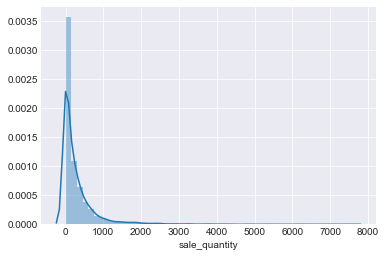

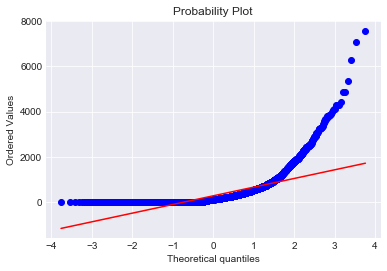

In [15]:
#histogram
sns.distplot(trainSaleDate2['sale_quantity']);
fig = plt.figure()
res = stats.probplot(trainSaleDate2['sale_quantity'], plot=plt)

* 销量图仍然偏离正太分布比较严重
* 考虑做个处理

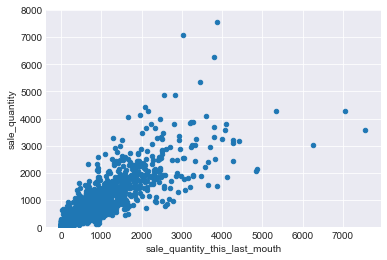

In [16]:
var = 'sale_quantity_this_last_mouth'
data = pd.concat([trainSaleDate2['sale_quantity'], trainSaleDate2[var]], axis=1)
data.plot.scatter(x=var, y='sale_quantity', ylim=(0,8000));

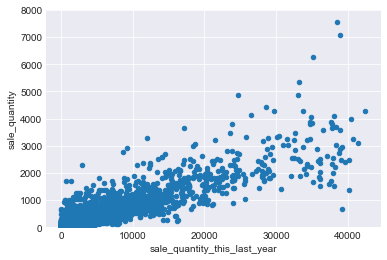

In [17]:
var = 'sale_quantity_this_last_year'
data = pd.concat([trainSaleDate2['sale_quantity'], trainSaleDate2[var]], axis=1)
data.plot.scatter(x=var, y='sale_quantity', ylim=(0,8000));

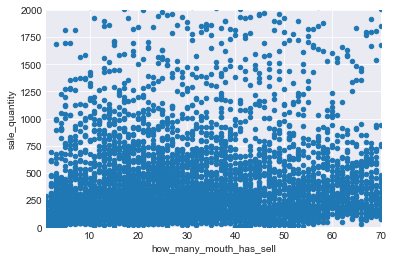

In [18]:
var = 'how_many_mouth_has_sell'
data = pd.concat([trainSaleDate2['sale_quantity'], trainSaleDate2[var]], axis=1)
data.plot.scatter(x=var, y='sale_quantity',xlim=(1, 70), ylim=(0,2000));

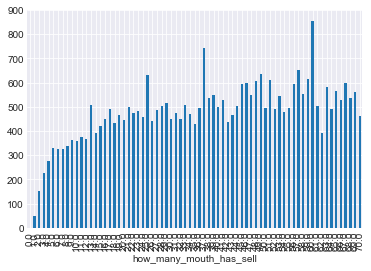

In [19]:
trainSaleDate2['sale_quantity'].groupby(trainSaleDate2['how_many_mouth_has_sell']).mean().plot.bar()
plt.show()

* 可以很明显的看出来, 本月销量和上月销量/上一年销量 成线性关系
* 本月销量 跟 销售月份有一定的关系, 特别是当销售月份小于3 的时候, 刚上市的汽车, 销量一般不会很好

In [1]:
# 热力散点图
k = 10 #number of variables for heatmap
corrmat = trainSaleDate2.corr()
cols = corrmat.nlargest(k, 'sale_quantity')['sale_quantity'].index
cm = np.corrcoef(trainSaleDate2[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 50}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

NameError: name 'trainSaleDate2' is not defined

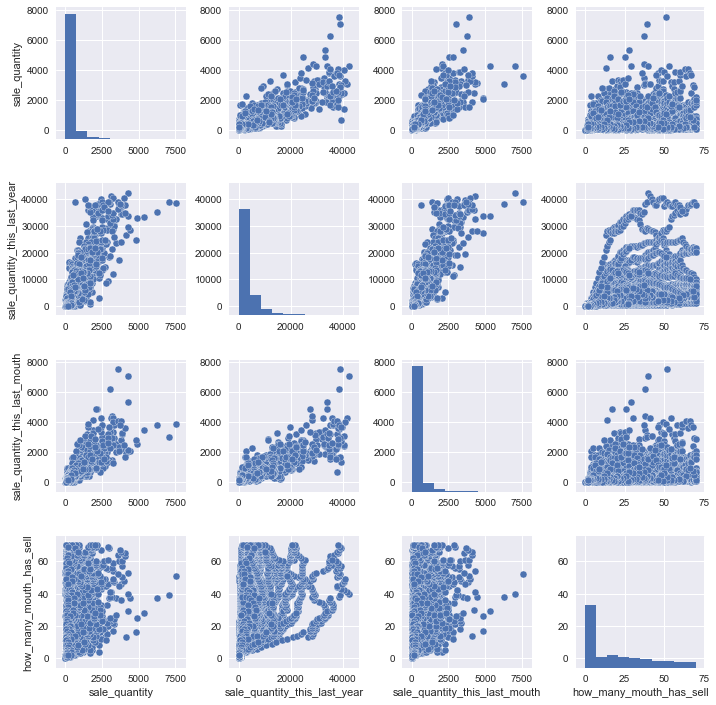

In [26]:
# 散点交叉图
sns.set()
cols = ['sale_quantity', 'sale_quantity_this_last_year', 'sale_quantity_this_last_mouth', 'how_many_mouth_has_sell'] #'emission_standards_id_3', 'compartment_3', 'TR_7', 'gearbox_type_DCT', 'type_id_2', 'gearbox_type_MT'
sns.pairplot(trainSaleDate2[cols], size = 2.5)
plt.show();

2-8月一个类, 其余一个类

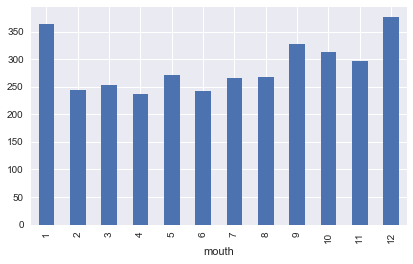

In [28]:
trainSaleDate2['sale_quantity'].groupby(trainSaleDate2['mouth']).mean().plot.bar()
plt.show()

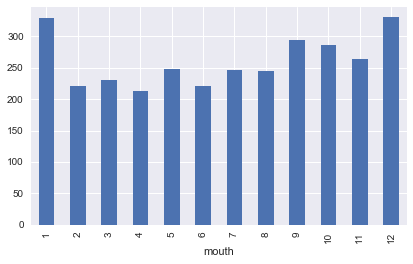

In [29]:
trainSaleDate['sale_quantity'].groupby(trainSaleDate['mouth']).mean().plot.bar()

深入挖掘看看每一年, 按月份是不是有线性关系

In [30]:
train_mouthes = trainSaleDate[['sale_quantity', 'year', 'mouth']]

In [31]:
train_2012 = train_mouthes[(train_mouthes['year']==2012)]

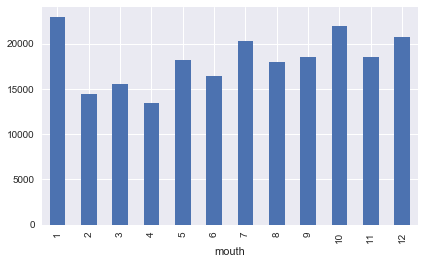

In [32]:
train_2012['sale_quantity'].groupby(train_2012['mouth']).sum().plot.bar()

In [33]:
train_2013 = train_mouthes[(train_mouthes['year']==2013)]

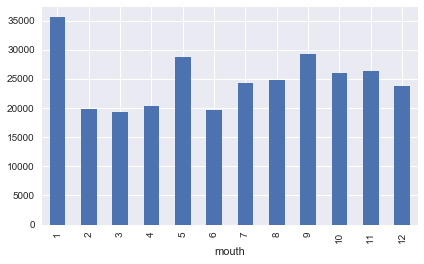

In [34]:
train_2013['sale_quantity'].groupby(train_2013['mouth']).sum().plot.bar()

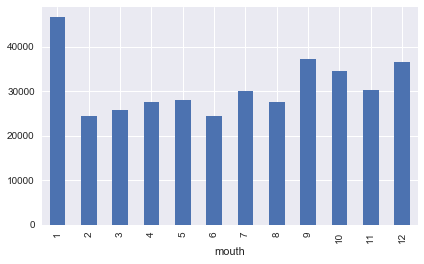

In [35]:
train_2014 = train_mouthes[(train_mouthes['year']==2014)]
train_2014['sale_quantity'].groupby(train_2014['mouth']).sum().plot.bar()

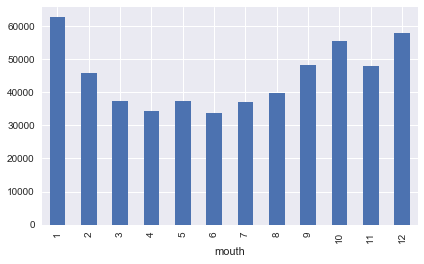

In [36]:
train_2015 = train_mouthes[(train_mouthes['year']==2015)]
train_2015['sale_quantity'].groupby(train_2015['mouth']).sum().plot.bar()

In [37]:
train_2016 = train_mouthes[(train_mouthes['year']==2016)]

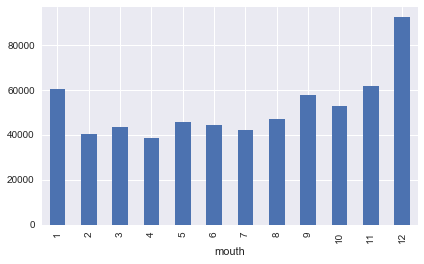

In [38]:
train_2016['sale_quantity'].groupby(train_2016['mouth']).sum().plot.bar()

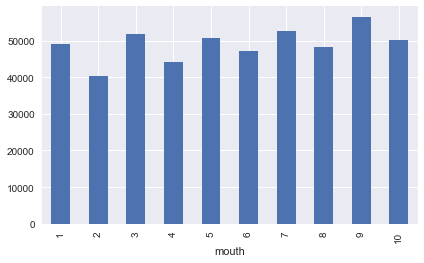

In [39]:
train_2017 = train_mouthes[(train_mouthes['year']==2017)]
train_2017['sale_quantity'].groupby(train_2017['mouth']).sum().plot.bar()

In [41]:
test.head()

,predict_date,class_id,predict_quantity
0,201711,103507,NaN
1,201711,124140,NaN
2,201711,125403,NaN
3,201711,136916,NaN
4,201711,169673,NaN


In [40]:
trainSaleDate.head()

,TR_0,TR_1,TR_4,TR_5,TR_5;4,TR_6,TR_7,TR_8,TR_8;7,TR_9,...,total_quality_mean,total_quality_min,type_id_1,type_id_2,type_id_3,type_id_4,wheelbase_max,wheelbase_mean,wheelbase_min,year
0,0,0,0,0,0,1,0,0,0,0,...,0.945055,0.880342,0,0,1,0,0.973262,0.973262,0.973262,2012
1,1,0,1,1,0,1,0,0,0,0,...,0.621083,0.555556,0,1,0,0,0.554813,0.554813,0.554813,2012
2,0,0,0,1,0,0,0,0,0,0,...,0.269231,0.170940,0,0,0,1,0.521390,0.354278,0.187166,2012
3,0,0,1,1,0,1,1,0,0,0,...,0.559829,0.461538,1,0,0,0,0.414439,0.387701,0.360963,2012
4,0,0,1,1,0,1,0,0,0,0,...,0.227066,0.222222,0,1,0,0,0.323529,0.322193,0.320856,2012


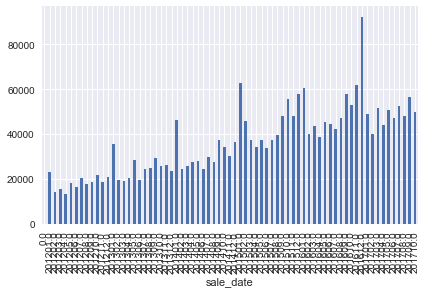

In [43]:
trainSaleDate['sale_quantity'].groupby(trainSaleDate['sale_date']).sum().plot.bar()
plt.show()

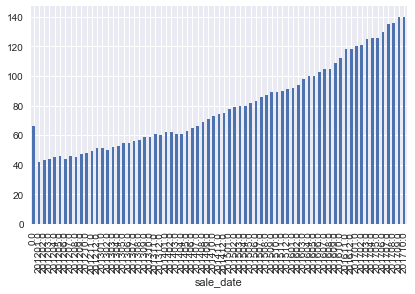

In [87]:
trainSaleDate["this_mouth_sale_class_count"].groupby(trainSaleDate['sale_date']).mean().plot.bar()

**销量会随着年增长而增长, 但是车型也是越来越多**

那么可能不是老牌子越卖越多, 而是新产品来满足新需求

画一些 class_id 的销量随月份变化的图来看看, 到底有什么规律

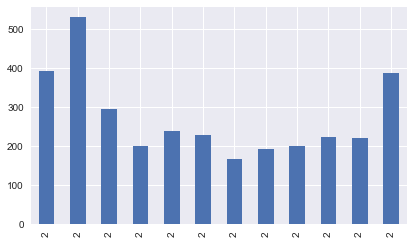

In [166]:
trainSaleDate[(trainSaleDate['class_id'] == 178529)&(trainSaleDate['year'] == 2016)]['sale_quantity'].plot.bar()

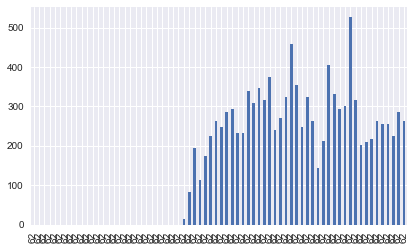

In [76]:
trainSaleDate[(trainSaleDate['class_id'] == 124140)]['sale_quantity'].plot.bar()

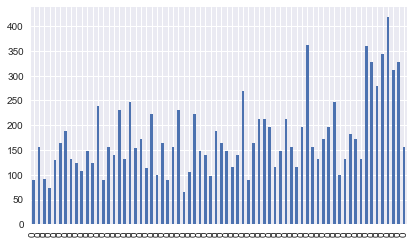

In [77]:
trainSaleDate[(trainSaleDate['class_id'] == 125403)]['sale_quantity'].plot.bar()

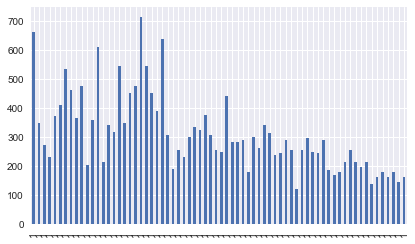

In [78]:
trainSaleDate[(trainSaleDate['class_id'] == 136916)]['sale_quantity'].plot.bar()

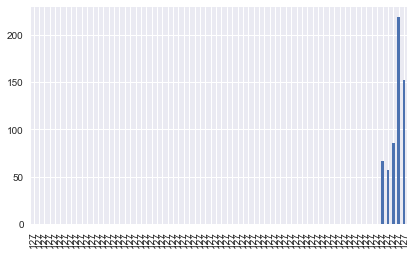

In [79]:
trainSaleDate[(trainSaleDate['class_id'] == 169673)]['sale_quantity'].plot.bar()

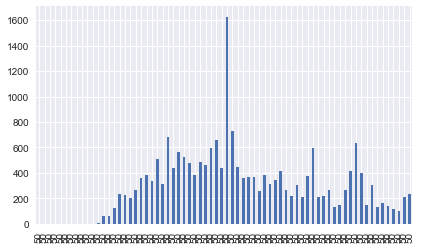

In [80]:
trainSaleDate[(trainSaleDate['class_id'] == 175962)]['sale_quantity'].plot.bar()

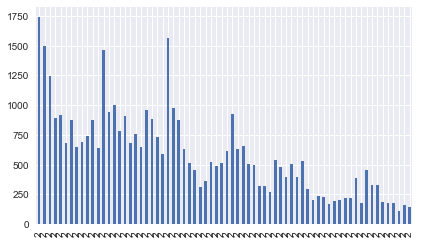

In [81]:
trainSaleDate[(trainSaleDate['class_id'] == 178529)]['sale_quantity'].plot.bar()

In [175]:
# 2017年10月, 销售月份和销量的关系
train_sale_2017 = trainSaleDate[(trainSaleDate['year'] == 2017)&(trainSaleDate['mouth'] == 9)][['class_id', 'how_many_mouth_has_sell', 'sale_quantity']]

In [75]:
trainDate[(trainDate['year']==2017)&(trainDate['mouth']==10)]

,sale_date,class_id,sale_quantity,year,mouth
5447,201710,103507,180,2017,10
5448,201710,124140,263,2017,10
5449,201710,125403,156,2017,10
5450,201710,136916,162,2017,10
5451,201710,169673,152,2017,10
5452,201710,175962,237,2017,10
5453,201710,178529,148,2017,10
5454,201710,186250,83,2017,10
5455,201710,194201,378,2017,10
5456,201710,194450,271,2017,10
